In [188]:
import json
import os
import sys

import joblib

# Добавляем корневую директорию проекта в sys.path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "../../")))

# Импортируем metrics из utils
from utils import metrics as mtc
from utils import preprocess_functions as ppf

In [189]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Готовим дата-сеты (предобработка)

In [190]:
reference = pd.read_csv("../../data/preprocessed/general/reference.csv")
train = pd.read_csv("../../data/splited/train.csv")
valid = pd.read_csv("../../data/splited/valid.csv")

abbr_dict = joblib.load("../../resources/general/abbreviations_dict.joblib")
region_dict = joblib.load("../../resources/general/region_dict.joblib")
blacklist_opf = joblib.load("../../resources/general/blacklist_opf.joblib")
stop_words_list = joblib.load("../../resources/general/stop_words_list.joblib")


In [191]:
import nltk
import pymorphy3
from nltk.tokenize import word_tokenize

# Загружаем необходимые ресурсы

nltk.download("punkt")

nltk.download("stopwords")

# Инициализация морфологического анализатора для русского языка
morph = pymorphy3.MorphAnalyzer()


# Пример функции для обработки текста
def lemmatize_text(text, stop_words_list):
    # Токенизация
    words = word_tokenize(text.lower(), language="russian")

    # Лемматизация
    lemmatized_words = [morph.parse(word)[0].normal_form for word in words]

    # Удаление стоп-слов
    # stop_words = set(stopwords.words("russian"))
    filtered_words = [word for word in lemmatized_words if word not in stop_words_list]

    return " ".join(filtered_words)
    # return " ".join(lemmatized_words)


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\filat\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\filat\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [192]:
def remove_short_words(text):
    words = text.split()  # разбиваем текст на слова
    filtered_words = [
        word for word in words if len(word) > 2
    ]  # фильтруем слова длиннее двух символов
    return " ".join(filtered_words)  # объединяем отфильтрованные слова в строку


In [193]:
reference["processed_name"] = reference.name.apply(
    ppf.simple_preprocess_text
).str.lower()
reference.processed_name = reference.processed_name.apply(ppf.replace_numbers_with_text)
reference.processed_name = reference.processed_name.apply(
    ppf.abbr_preprocess_text, args=(abbr_dict, False, False, True, False)
)
reference.processed_name = reference.processed_name.apply(
    ppf.process_region, args=(list(region_dict.keys()),)
)
reference.processed_name = reference.processed_name.apply(
    ppf.remove_substrings, args=(blacklist_opf,)
)
reference.processed_name = reference.processed_name.apply(ppf.simple_preprocess_text)
reference.processed_name = reference.processed_name.apply(
    lemmatize_text, args=(stop_words_list,)
)
reference.processed_name = reference.processed_name.apply(remove_short_words)
reference.head(1)


,id,name,region,processed_name
0,69,Кировска,мурманская область,кировск


In [195]:
train["processed_name"] = train.name.apply(ppf.simple_preprocess_text).str.lower()
train.processed_name = train.processed_name.apply(ppf.replace_numbers_with_text)
train.processed_name = train.processed_name.apply(
    ppf.abbr_preprocess_text, args=(abbr_dict, False, False, True, False)
)
train["region"] = train.processed_name.apply(
    ppf.process_region, args=(list(region_dict.keys()), True)
)
train.processed_name = train.processed_name.apply(
    ppf.process_region, args=(list(region_dict.keys()),)
)
train.processed_name = train.processed_name.apply(
    ppf.remove_substrings, args=(blacklist_opf,)
)
train.processed_name = train.processed_name.apply(ppf.simple_preprocess_text)
train.processed_name = train.processed_name.apply(
    lemmatize_text, args=(stop_words_list,)
)
train.processed_name = train.processed_name.apply(remove_short_words)
train.head(1)


,name,school_id,processed_name,region
0,"ХМАО-Югра, СШ г. Покачи",173,спортивный школа покачи,ханты мансийский автономный округ


In [196]:
valid["processed_name"] = valid.name.apply(ppf.simple_preprocess_text).str.lower()
valid.processed_name = valid.processed_name.apply(ppf.replace_numbers_with_text)
valid.processed_name = valid.processed_name.apply(
    ppf.abbr_preprocess_text, args=(abbr_dict, False, False, True, False)
)
valid["region"] = valid.processed_name.apply(
    ppf.process_region, args=(list(region_dict.keys()), True)
)

valid.processed_name = valid.processed_name.apply(
    ppf.process_region, args=(list(region_dict.keys()),)
)
valid.processed_name = valid.processed_name.apply(
    ppf.remove_substrings, args=(blacklist_opf,)
)
valid.processed_name = valid.processed_name.apply(ppf.simple_preprocess_text)
valid.processed_name = valid.processed_name.apply(
    lemmatize_text, args=(stop_words_list,)
)
valid.processed_name = valid.processed_name.apply(remove_short_words)
valid.head(1)


,name,school_id,processed_name,region
0,КФК Е. Герасимовой,1843,клуб фигурный катание герасимов,None


### Преобразования в np.array

In [197]:
x_train = train["processed_name"].to_numpy(dtype="str").flatten()
y_train = train["school_id"].to_numpy(dtype="int").flatten()
region_train = train["region"].to_numpy(dtype="str").flatten()

x_valid = valid["processed_name"].to_numpy(dtype="str").flatten()
y_valid = valid["school_id"].to_numpy(dtype="int").flatten()
region_valid = valid["region"].to_numpy(dtype="str").flatten()

reference_id = reference["id"].to_numpy(dtype="int").flatten()
reference_name = reference["processed_name"].to_numpy(dtype="str").flatten()
reference_region = reference["region"].to_numpy(dtype="str").flatten()

In [198]:
joblib.dump(reference_id, "../../resources/exp44/reference_id.joblib")
joblib.dump(reference_name, "../../resources/exp44/reference_name.joblib")
joblib.dump(reference_region, "../../resources/exp44/reference_region.joblib")

['../../resources/exp44/reference_region.joblib']

# Модель

In [199]:
from sklearn.metrics.pairwise import euclidean_distances, manhattan_distances


def calculate_similarity(x, y, method="cosine"):
    if method == "cosine":
        return cosine_similarity(x, y)
    elif method == "euclidean":
        return -euclidean_distances(x, y)  # Инвертируем, чтобы максимизировать схожесть
    elif method == "manhattan":
        return -manhattan_distances(x, y)  # Инвертируем, чтобы максимизировать схожесть
    else:
        raise ValueError(f"Unknown similarity method: {method}")


def find_matches(
    x_vec,
    x_region,
    reference_id,
    reference_vec,
    reference_region,
    top_k=5,
    threshold=0.9,
    filter_by_region=True,
    empty_region="all",
    similarity_method="cosine",
):
    y_pred = []
    manual_review = []

    for i, x in enumerate(x_vec):
        # Фильтруем reference_vec и reference_id по текущему региону, если включена фильтрация по регионам
        if filter_by_region:
            # Фильтруем reference_vec и reference_id по текущему региону
            current_region = x_region[i]
            region_mask = reference_region == current_region
            filtered_reference_vec = reference_vec[region_mask]
            filtered_reference_id = reference_id[region_mask]

            # Способ обработки, если в текущем регионе нет школ для сравнения
            if empty_region == "all":
                # Если в текущем регионе нет школ для сравнения, используем все школы
                if filtered_reference_vec.shape[0] == 0:
                    filtered_reference_vec = reference_vec
                    filtered_reference_id = reference_id
            else:
                if filtered_reference_vec.shape[0] == 0:
                    # Если в текущем регионе нет школ для сравнения, то помечаем на ручную обработку
                    manual_review.append(x)
                    top_matches = [(None, 0.0)] * top_k
                    y_pred.append(top_matches)
                    continue
        else:
            filtered_reference_vec = reference_vec
            filtered_reference_id = reference_id

        # Вычисляем выбранное расстояние
        similarities = calculate_similarity(
            x, filtered_reference_vec, method=similarity_method
        ).flatten()
        top_indices = similarities.argsort()[-top_k:][::-1]
        max_similarity = max(similarities)

        # Учитываем пороговое значение для различных методов
        if similarity_method == "cosine":
            if max_similarity < threshold:
                manual_review.append(x)
                top_matches = [(None, 0.0)] * top_k
            else:
                top_matches = [
                    (filtered_reference_id[i], similarities[i]) for i in top_indices
                ]
                if len(top_matches) < top_k:
                    top_matches += [(None, 0.0)] * (top_k - len(top_matches))
        else:  # Для других методов расстояний (евклидово и манхэттенское)
            if max_similarity > -threshold:  # Обратите внимание на инверсию
                manual_review.append(x)
                top_matches = [(None, 0.0)] * top_k
            else:
                top_matches = [
                    (filtered_reference_id[i], -similarities[i]) for i in top_indices
                ]
                if len(top_matches) < top_k:
                    top_matches += [(None, 0.0)] * (top_k - len(top_matches))

        y_pred.append(top_matches)

    return y_pred, manual_review

# Векторизация

In [200]:
# Векторизация текстов
vectorizer = TfidfVectorizer().fit(np.append(x_train, reference_name))

reference_vec = vectorizer.transform(reference_name)
x_vec_valid = vectorizer.transform(x_valid)

In [201]:
joblib.dump(reference_vec, "../../resources/exp44/reference_vec.joblib")
joblib.dump(vectorizer, "../../resources/exp44/vectorizer.joblib")

['../../resources/exp44/vectorizer.joblib']

In [202]:
# Массив значений threshold
threshold_values = np.linspace(0, 1.0, 25)

# Запуск функции и сбор метрик
metrics_list = []
for threshold in threshold_values:
    y_pred, manual_review = find_matches(
        x_vec_valid,
        region_valid,
        reference_id,
        reference_vec,
        reference_region,
        top_k=5,
        threshold=threshold,
        filter_by_region=True,
        empty_region="all",
        # similarity_method="euclidean",
        similarity_method="cosine",
        # similarity_method="manhattan",
    )
    metrics = mtc.calculate_metrics(y_valid, y_pred, manual_review)
    metrics_list.append(metrics)

# Преобразование метрик в удобный формат для построения графика
auto_error_rate_values = [metrics["auto_error_rate"] for metrics in metrics_list]
manual_processing_rate_values = [
    metrics["manual_processing_rate"] for metrics in metrics_list
]
# general_spend_values = [metrics['general_spend'] for metrics in metrics_list]
general_error_values = [metrics["general_error"] for metrics in metrics_list]

In [203]:
plots_json = {
    "threshold_values": threshold_values.tolist(),
    "auto_error_rate_values": auto_error_rate_values,
    "manual_processing_rate_values": manual_processing_rate_values,
    "general_error_values": general_error_values,
}

# Сохраняем словарь в файл JSON
with open("../../plots/exp44.json", "w", encoding="utf-8") as f:
    json.dump(plots_json, f, ensure_ascii=False, indent=4)

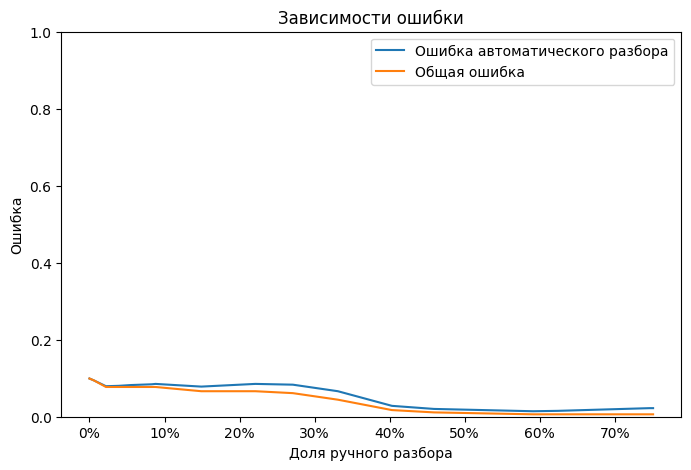

In [204]:
from matplotlib.ticker import PercentFormatter

# Построение графика
plt.figure(figsize=(8, 5))

# plt.subplot(1, 2, 1)
plt.plot(
    manual_processing_rate_values,
    auto_error_rate_values,
    label="Ошибка автоматического разбора",
)
plt.plot(manual_processing_rate_values, general_error_values, label="Общая ошибка")
plt.xlabel("Доля ручного разбора")
plt.ylabel("Ошибка")
plt.title("Зависимости ошибки")
plt.legend()

# Установка формата осей в процентах
plt.gca().xaxis.set_major_formatter(PercentFormatter(1))
# plt.gca().yaxis.set_major_formatter(PercentFormatter(1))

# Установка максимального значения оси y
plt.ylim(0, 1.0)

plt.show()

In [205]:
y_pred, manual_review = find_matches(
    x_vec_valid,
    region_valid,
    reference_id,
    reference_vec,
    reference_region,
    top_k=5,
    threshold=-1,
    filter_by_region=True,
    empty_region="all",  # is ignored if filter_by_region=False
    # similarity_method="euclidean",
    similarity_method="cosine",
    # similarity_method="manhattan",
)

metrics = mtc.calculate_metrics(y_valid, y_pred, manual_review)

# Сохраняем словарь в файл JSON
with open("../../evaluations/exp44.json", "w", encoding="utf-8") as f:
    json.dump(metrics, f, ensure_ascii=False, indent=4)

metrics

{'Accuracy@1': 0.901,
 'Accuracy@3': 0.994,
 'Accuracy@5': 0.994,
 'Accuracy@10': 0.994,
 'auto_error_rate': 0.099,
 'manual_processing_rate': 0.0,
 'general_error': 0.099}

In [206]:
answers_distance = []
for pred in y_pred:
    answers_distance.append(round((pred[0][1] - pred[1][1]) / pred[0][1], 2))

(pd.Series(answers_distance) < 0.2).sum()


27

In [207]:
for i, pred in enumerate(y_pred):
    if pred[0][0] != y_valid[i]:
        print(f"Запись {i} - НЕВЕРНО")
    else:
        print(f"Запись {i}")
    print(f"--> Запрос: {x_valid[i]}, регион: {region_valid[i]}")
    print(
        f"--> Расстояние от второго до первого: {round((pred[0][1] - pred[1][1])/pred[0][1], 2)}, "
        f"разность первого и второго: {round(pred[0][1] - pred[1][1], 2)}"
    )
    print(f"--> Верный id: {y_valid[i]}")
    print("--> Варианты модели:")
    for candidate in pred:
        candidate_name = reference_name[np.where(reference_id == candidate[0])[0]]
        print(
            f"    --> {candidate[0]}, вероятность {round(candidate[1], 2)}, имя: {candidate_name}"
        )
    print()


Запись 0
--> Запрос: клуб фигурный катание герасимов, регион: None
--> Расстояние от второго до первого: 0.59, разность первого и второго: 0.59
--> Верный id: 1843
--> Варианты модели:
    --> 1843, вероятность 1.0, имя: ['клуб фигурный катание герасимов']
    --> 236, вероятность 0.41, имя: ['федерация фигурный катание спортивный клуб']
    --> 277, вероятность 0.38, имя: ['клуб фигурный катание динамо']
    --> 611, вероятность 0.37, имя: ['клуб фигурный катание айсберг']
    --> 292, вероятность 0.35, имя: ['школа фигурный катание']

Запись 1 - НЕВЕРНО
--> Запрос: московский академия фигурный катание конёк школа хрустальный, регион: москва
--> Расстояние от второго до первого: 0.26, разность первого и второго: 0.2
--> Верный id: 244
--> Варианты модели:
    --> 96, вероятность 0.79, имя: ['московский академия фигурный катание конёк']
    --> 244, вероятность 0.58, имя: ['хрустальный']
    --> 10, вероятность 0.36, имя: ['академия синхронный катание конёк']
    --> 20, вероятность 0.

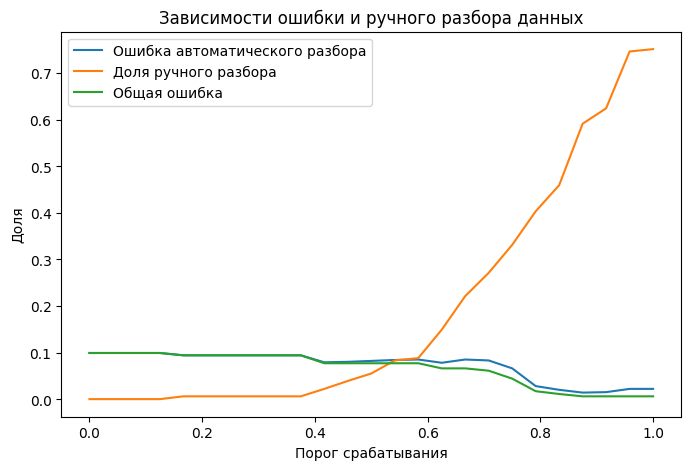

In [208]:
# Построение графика
plt.figure(figsize=(8, 5))

# plt.subplot(1, 2, 1)
plt.plot(
    threshold_values, auto_error_rate_values, label="Ошибка автоматического разбора"
)
plt.plot(
    threshold_values,
    manual_processing_rate_values,
    label="Доля ручного разбора",
)
plt.plot(threshold_values, general_error_values, label="Общая ошибка")
plt.xlabel("Порог срабатывания")
plt.ylabel("Доля")
plt.title("Зависимости ошибки и ручного разбора данных")
plt.legend()

plt.show()
